# **Decision Tree Regressor**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from scipy.stats import skew,skewtest, kurtosis
from scipy.stats import pearsonr
import time

## Importing Data

In [2]:
df = pd.read_excel('Backhoe_Emission.xlsx').drop(columns='No')
df

,Backhoe,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C],NOx[g/s]
0,1,65621.6,0.000000,833.0,12,2,22.0,0.024090
1,1,65621.6,0.012346,800.0,12,2,22.0,0.030320
2,1,65621.6,0.012346,826.0,12,2,22.0,0.030730
3,1,65621.6,0.012346,831.0,12,2,22.0,0.023693
4,1,65621.6,0.012346,834.0,12,2,22.0,0.026107
...,...,...,...,...,...,...,...,...
37523,8,72332.9,0.975904,1676.0,36,2,41.0,0.058830
37524,8,72332.9,0.975904,1683.0,36,2,42.0,0.059500
37525,8,72332.9,0.975904,1846.0,36,2,42.0,0.059640
37526,8,72332.9,0.987952,1876.0,36,2,42.0,0.056200


## Preprocessing

### Missing Values

In [3]:
df.isna().sum()

Backhoe        0
HP(watt)       0
Norm_MAP       0
RPM            1
Age            0
Engine_Tier    0
TEMP[C]        1
NOx[g/s]       0
dtype: int64

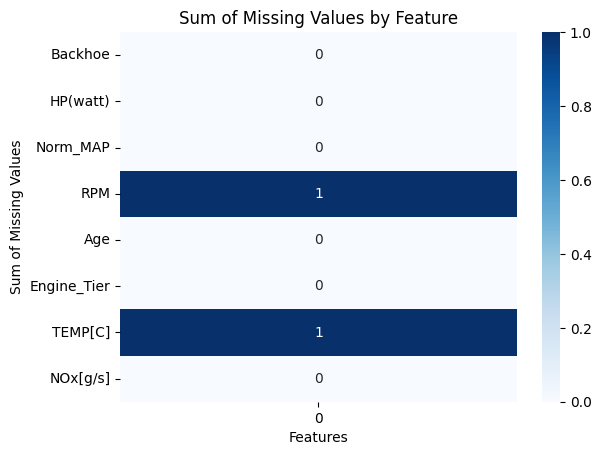

In [4]:
sns.heatmap(df.isnull().sum().to_frame(), annot=True, cmap='Blues')
plt.xlabel('Features')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values by Feature')
plt.show()

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

Backhoe        0
HP(watt)       0
Norm_MAP       0
RPM            0
Age            0
Engine_Tier    0
TEMP[C]        0
NOx[g/s]       0
dtype: int64

### Duplicates

In [7]:
df.duplicated().sum()

1870

### Desciptive Analysis

In [8]:
df_describe = df.describe().T
df_describe = df_describe.drop(columns=['count', '25%', '50%', '75%'], axis=1)
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['variance'] = df_describe['std'] ** 2
def get_mode(x):
    mode_values = x.mode().values
    if len(mode_values) == 1:
        return mode_values[0]
    else:
        return ', '.join(map(str, mode_values))

df_describe['mode'] = df.apply(get_mode)
df_describe

,mean,std,min,max,range,variance,mode
Backhoe,4.097903,2.402267,1.00000,8.00000,7.00000,5.770887e+00,2.00000
HP(watt),69085.239092,3799.646439,65621.60000,73824.30000,8202.70000,1.443731e+07,65621.60000
Norm_MAP,0.205430,0.172965,0.00000,1.01250,1.01250,2.991697e-02,0.04000
RPM,1285.718099,405.758652,92.00000,5000.00000,4908.00000,1.646401e+05,902.00000
Age,73.321608,26.266663,12.00000,96.00000,84.00000,6.899376e+02,84.00000
Engine_Tier,1.257601,0.558013,0.00000,2.00000,2.00000,3.113780e-01,1.00000
TEMP[C],41.096399,15.470683,12.00000,127.00000,115.00000,2.393420e+02,30.00000
NOx[g/s],0.030345,0.019430,0.00123,0.16052,0.15929,3.775173e-04,0.01629


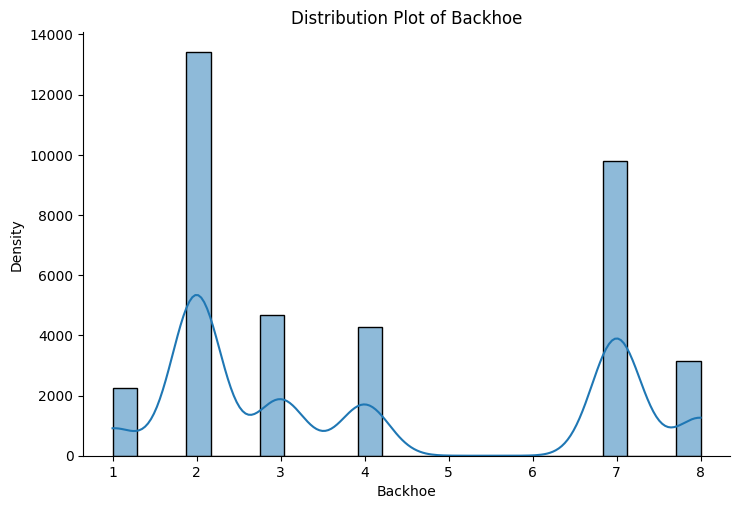

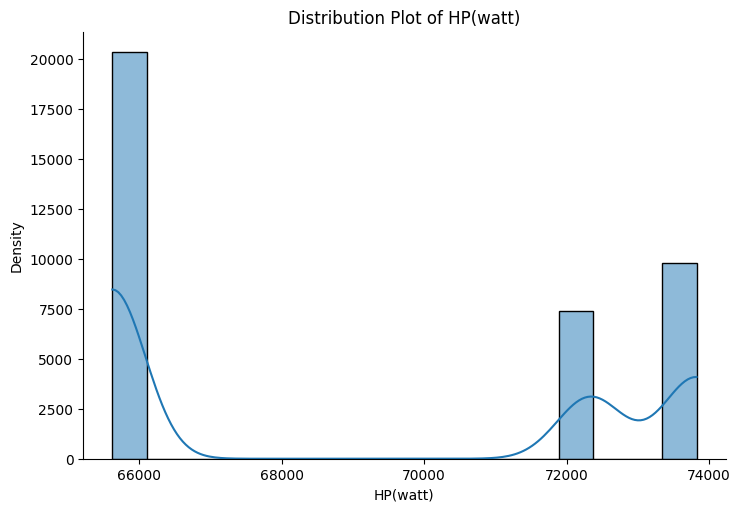

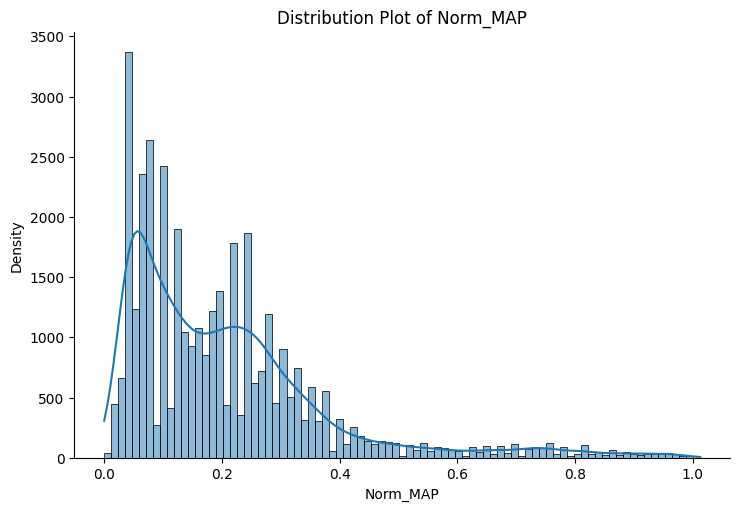

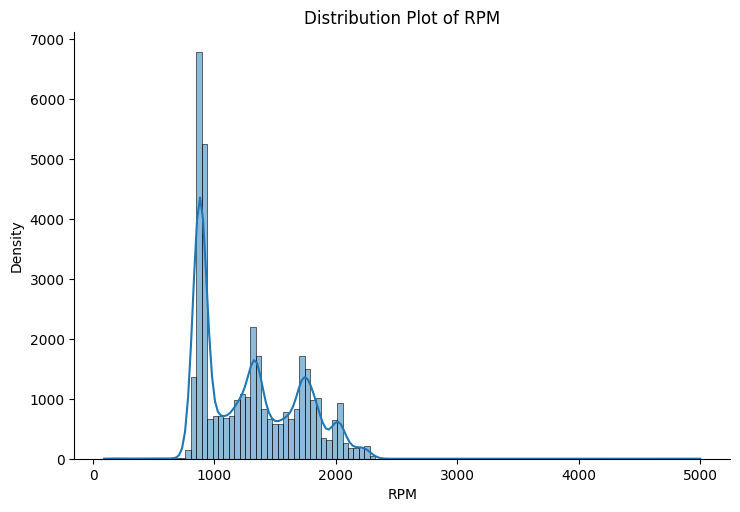

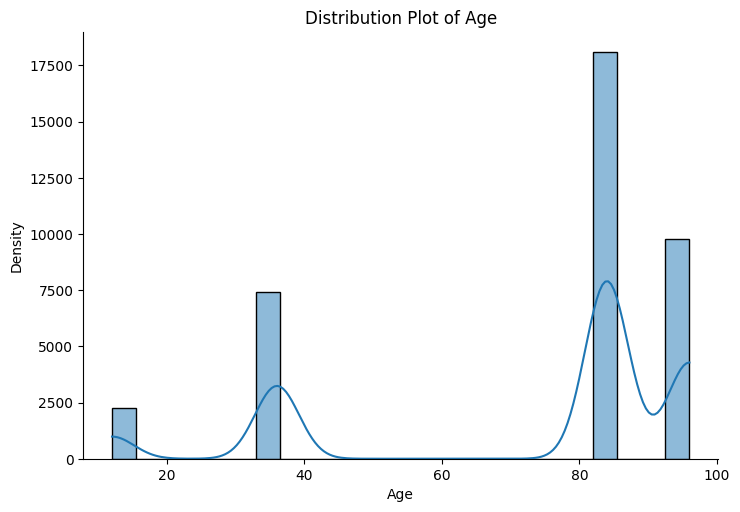

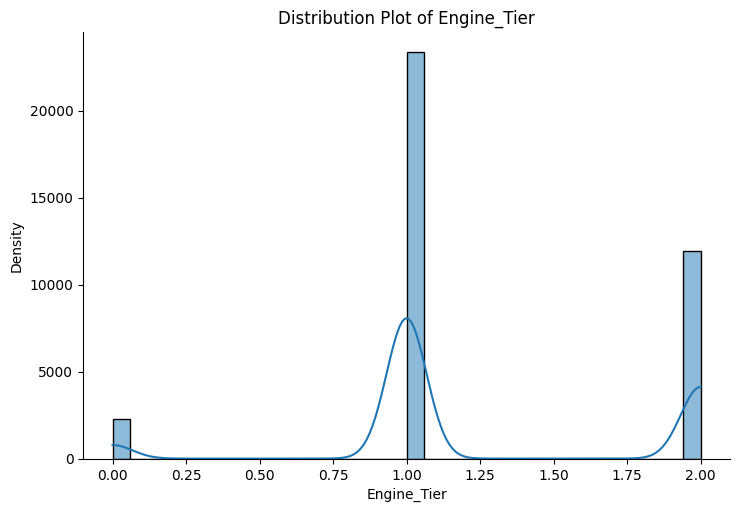

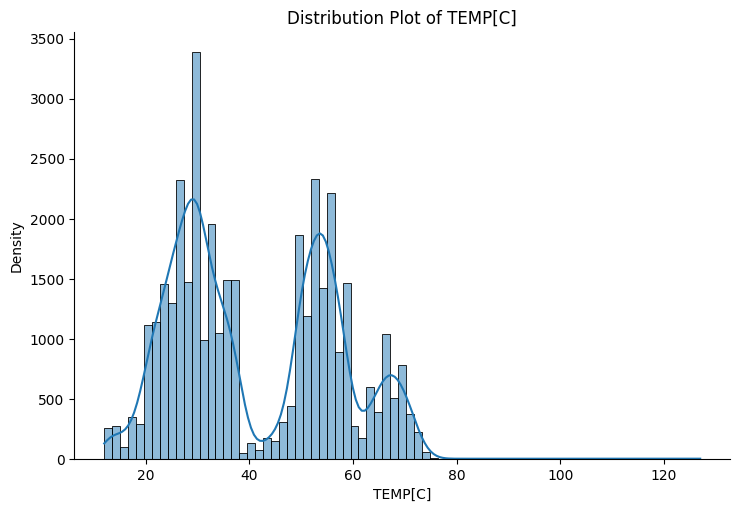

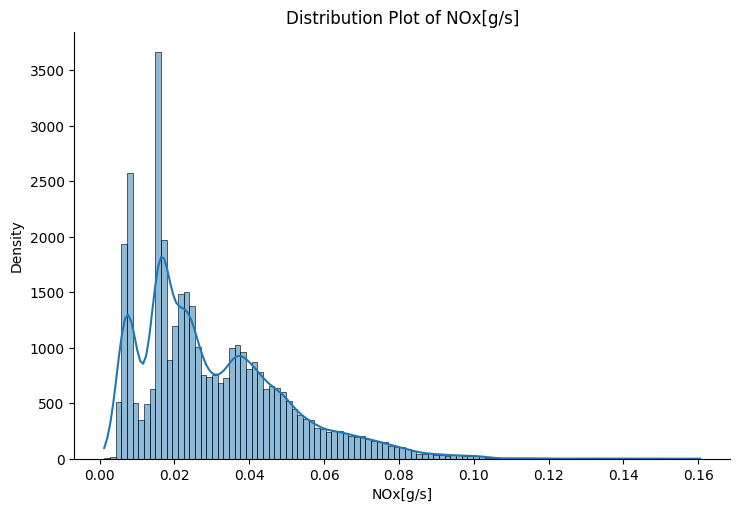

In [9]:
for column in df.columns:
    sns.displot(df[column], kde=True, height=5, aspect=1.5)
    plt.title(f'Distribution Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

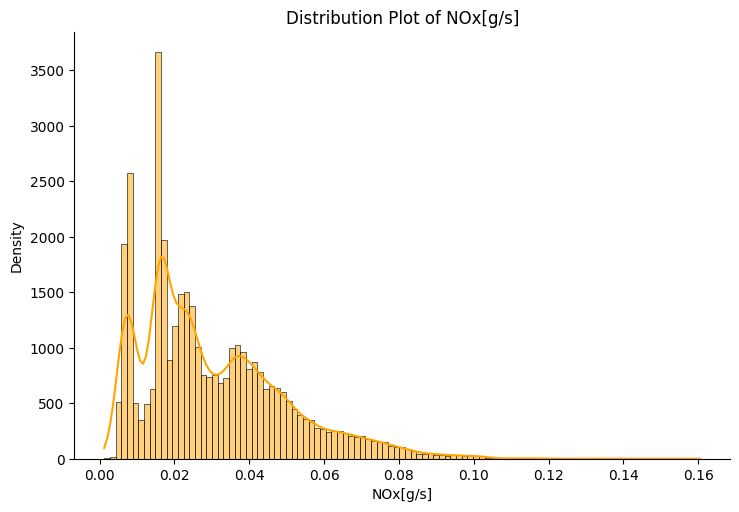

In [10]:
sns.displot(df['NOx[g/s]'], kde=True, height=5, aspect=1.5, color='orange')
plt.title('Distribution Plot of NOx[g/s]')
plt.xlabel('NOx[g/s]')
plt.ylabel('Density')
plt.show()

### Skewness & Kurtosis

In [11]:
skewness_X = df.drop(columns='NOx[g/s]').apply(lambda x: skew(x, bias=True, nan_policy='omit'))
skewness_y = skew(df['NOx[g/s]'], bias=True, nan_policy='omit')
kurtosis_X = df.drop(columns='NOx[g/s]').apply(lambda x: kurtosis(x, nan_policy='omit'))
kurtosis_y = kurtosis(df['NOx[g/s]'], nan_policy='omit')

In [12]:
print("Skewness independent variables:")
print(skewness_X)
print("\nSkewness dependent variable (NOx[g/s]):")
print(skewness_y)

Skewness independent variables:
Backhoe        0.440079
HP(watt)       0.218597
Norm_MAP       1.807995
RPM            0.592456
Age           -1.130582
Engine_Tier   -0.000693
TEMP[C]        0.264903
dtype: float64

Skewness dependent variable (NOx[g/s]):
1.0385038342630495


In [13]:
print("Kurtosis independent variables:")
print(kurtosis_X)
print("\nKurtosis dependent variable (NOx[g/s]):")
print(kurtosis_y)

Kurtosis independent variables:
Backhoe       -1.482144
HP(watt)      -1.889719
Norm_MAP       3.937857
RPM           -0.305166
Age           -0.253212
Engine_Tier   -0.426777
TEMP[C]       -1.176410
dtype: float64

Kurtosis dependent variable (NOx[g/s]):
1.0443586681328556


### Correlation Test

<Axes: >

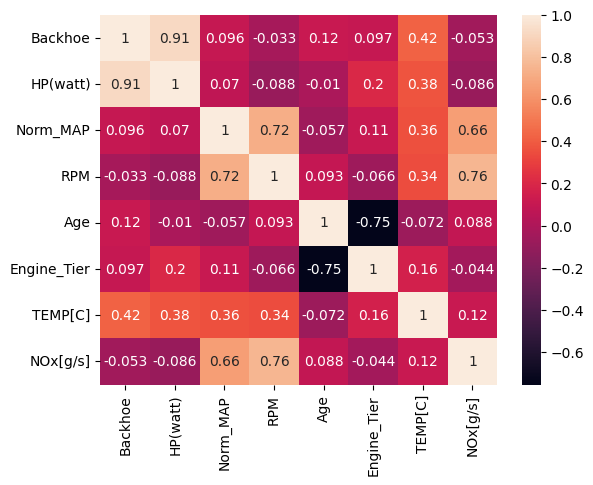

In [14]:
corr_matrix = df.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)

In [15]:
corr_matrix = df.corr(method='pearson')

# Step 2: Calculate p-values
def calculate_p_values(df):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for row in df.columns:
        for col in df.columns:
            if row == col:
                p_values.loc[row, col] = np.nan  # No p-value for self-correlation
            else:
                _, p_value = pearsonr(df[row], df[col])
                p_values.loc[row, col] = p_value
    return p_values

p_values_matrix = calculate_p_values(df)

# Step 3: Combine correlation coefficients and p-values into a single DataFrame
combined_matrix = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns)

# Fill the combined matrix with formatted strings
for row in corr_matrix.index:
    for col in corr_matrix.columns:
        if row == col:
            combined_matrix.loc[row, col] = (np.nan, np.nan)  # No correlation or p-value for self-correlation
        else:
            r_value = f"r-value: {corr_matrix.loc[row, col]:.4f}"
            p_value = f"P-value: {p_values_matrix.loc[row, col]:.4f}"
            combined_matrix.loc[row, col] = (r_value, p_value)

# Display the combined DataFrame
combined_matrix

,Backhoe,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C],NOx[g/s]
Backhoe,"(nan, nan)","(r-value: 0.9120, P-value: 0.0000)","(r-value: 0.0963, P-value: 0.0000)","(r-value: -0.0326, P-value: 0.0000)","(r-value: 0.1158, P-value: 0.0000)","(r-value: 0.0969, P-value: 0.0000)","(r-value: 0.4239, P-value: 0.0000)","(r-value: -0.0528, P-value: 0.0000)"
HP(watt),"(r-value: 0.9120, P-value: 0.0000)","(nan, nan)","(r-value: 0.0702, P-value: 0.0000)","(r-value: -0.0881, P-value: 0.0000)","(r-value: -0.0101, P-value: 0.0511)","(r-value: 0.2045, P-value: 0.0000)","(r-value: 0.3758, P-value: 0.0000)","(r-value: -0.0862, P-value: 0.0000)"
Norm_MAP,"(r-value: 0.0963, P-value: 0.0000)","(r-value: 0.0702, P-value: 0.0000)","(nan, nan)","(r-value: 0.7197, P-value: 0.0000)","(r-value: -0.0570, P-value: 0.0000)","(r-value: 0.1071, P-value: 0.0000)","(r-value: 0.3560, P-value: 0.0000)","(r-value: 0.6559, P-value: 0.0000)"
RPM,"(r-value: -0.0326, P-value: 0.0000)","(r-value: -0.0881, P-value: 0.0000)","(r-value: 0.7197, P-value: 0.0000)","(nan, nan)","(r-value: 0.0929, P-value: 0.0000)","(r-value: -0.0664, P-value: 0.0000)","(r-value: 0.3446, P-value: 0.0000)","(r-value: 0.7572, P-value: 0.0000)"
Age,"(r-value: 0.1158, P-value: 0.0000)","(r-value: -0.0101, P-value: 0.0511)","(r-value: -0.0570, P-value: 0.0000)","(r-value: 0.0929, P-value: 0.0000)","(nan, nan)","(r-value: -0.7543, P-value: 0.0000)","(r-value: -0.0720, P-value: 0.0000)","(r-value: 0.0875, P-value: 0.0000)"
Engine_Tier,"(r-value: 0.0969, P-value: 0.0000)","(r-value: 0.2045, P-value: 0.0000)","(r-value: 0.1071, P-value: 0.0000)","(r-value: -0.0664, P-value: 0.0000)","(r-value: -0.7543, P-value: 0.0000)","(nan, nan)","(r-value: 0.1575, P-value: 0.0000)","(r-value: -0.0444, P-value: 0.0000)"
TEMP[C],"(r-value: 0.4239, P-value: 0.0000)","(r-value: 0.3758, P-value: 0.0000)","(r-value: 0.3560, P-value: 0.0000)","(r-value: 0.3446, P-value: 0.0000)","(r-value: -0.0720, P-value: 0.0000)","(r-value: 0.1575, P-value: 0.0000)","(nan, nan)","(r-value: 0.1157, P-value: 0.0000)"
NOx[g/s],"(r-value: -0.0528, P-value: 0.0000)","(r-value: -0.0862, P-value: 0.0000)","(r-value: 0.6559, P-value: 0.0000)","(r-value: 0.7572, P-value: 0.0000)","(r-value: 0.0875, P-value: 0.0000)","(r-value: -0.0444, P-value: 0.0000)","(r-value: 0.1157, P-value: 0.0000)","(nan, nan)"


In [16]:
corr_matrix = df.corr(method='pearson')

# Step 2: Calculate p-values
def calculate_p_values(df):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for row in df.columns:
        for col in df.columns:
            if row == col:
                p_values.loc[row, col] = np.nan  # No p-value for self-correlation
            else:
                _, p_value = pearsonr(df[row], df[col])
                p_values.loc[row, col] = p_value
    return p_values

p_values_matrix = calculate_p_values(df)

# Step 3: Combine correlation coefficients and p-values into a single DataFrame
result_df = pd.DataFrame({
    'Correlation': corr_matrix.unstack(),
    'P-Value': p_values_matrix.unstack()
}).reset_index()

# Rename columns for clarity
result_df.columns = ['Variable 1', 'Variable 2', 'Correlation', 'P-Value']

# Display the result DataFrame
result_df

,Variable 1,Variable 2,Correlation,P-Value
0,Backhoe,Backhoe,1.000000,NaN
1,Backhoe,HP(watt),0.911953,0.0
2,Backhoe,Norm_MAP,0.096304,0.0
3,Backhoe,RPM,-0.032576,0.0
4,Backhoe,Age,0.115767,0.0
...,...,...,...,...
59,NOx[g/s],RPM,0.757209,0.0
60,NOx[g/s],Age,0.087536,0.0
61,NOx[g/s],Engine_Tier,-0.044388,0.0
62,NOx[g/s],TEMP[C],0.115730,0.0


In [17]:
from scipy.stats import pearsonr


r_value, p_value = pearsonr(df['Backhoe'], df['HP(watt)'])

# Menampilkan hasil
print(f"Koefisien Korelasi: {r_value}")
print(f"P-Value: {p_value}")


Koefisien Korelasi: 0.9119531314912696
P-Value: 0.0


### Train Test Split

In [18]:
X = df[['HP(watt)', 'Norm_MAP', 'RPM', 'Age', 'Engine_Tier','TEMP[C]']]
y = df['NOx[g/s]']

In [19]:
X.head()

,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C]
0,65621.6,0.000000,833.0,12,2,22.0
1,65621.6,0.012346,800.0,12,2,22.0
2,65621.6,0.012346,826.0,12,2,22.0
3,65621.6,0.012346,831.0,12,2,22.0
4,65621.6,0.012346,834.0,12,2,22.0


In [20]:
y.head()

0    0.024090
1    0.030320
2    0.030730
3    0.023693
4    0.026107
Name: NOx[g/s], dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26268, 6)
(11259, 6)
(26268,)
(11259,)


### Standaridzation

In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [24]:
X_test_scaled
column_names = X_train.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_train_scaled_df.head()

,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C]
0,0.856722,0.120079,-0.985892,-1.424270,1.333261,1.022972
1,-0.909959,-0.142326,0.523167,0.405830,1.333261,-0.717838
2,-0.909959,-0.958696,-0.948845,0.405830,-0.456594,-1.169158
3,-0.909959,-1.075321,-0.958724,0.405830,-0.456594,-1.040210
4,1.249318,-1.191945,-1.035288,0.863354,-0.456594,-0.459940


In [25]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(26268, 6)
(26268,)
(11259, 6)
(11259,)


In [26]:
column_names = X_train.columns
combined_df = pd.concat([X_train.reset_index(drop=True), X_train_scaled_df.reset_index(drop=True)], axis=1)
combined_df.columns = [f'{col}_original' for col in column_names] + [f'{col}_scaled' for col in column_names]
combined_df.head()

,HP(watt)_original,Norm_MAP_original,RPM_original,Age_original,Engine_Tier_original,TEMP[C]_original,HP(watt)_scaled,Norm_MAP_scaled,RPM_scaled,Age_scaled,Engine_Tier_scaled,TEMP[C]_scaled
0,72332.9,0.225,885.0,36,2,57.0,0.856722,0.120079,-0.985892,-1.424270,1.333261,1.022972
1,65621.6,0.180,1496.0,84,2,30.0,-0.909959,-0.142326,0.523167,0.405830,1.333261,-0.717838
2,65621.6,0.040,900.0,84,1,23.0,-0.909959,-0.958696,-0.948845,0.405830,-0.456594,-1.169158
3,65621.6,0.020,896.0,84,1,25.0,-0.909959,-1.075321,-0.958724,0.405830,-0.456594,-1.040210
4,73824.3,0.000,865.0,96,1,34.0,1.249318,-1.191945,-1.035288,0.863354,-0.456594,-0.459940


In [27]:
# combined_df.to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\Standarized_Data.xlsx', index=False)

## Modelling

In [28]:
dtr = DecisionTreeRegressor(random_state=42)

In [29]:
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [30]:
dtr.fit(X_train_scaled,y_train)

DecisionTreeRegressor(random_state=42)

In [31]:
y_pred = dtr.predict(X_test_scaled)

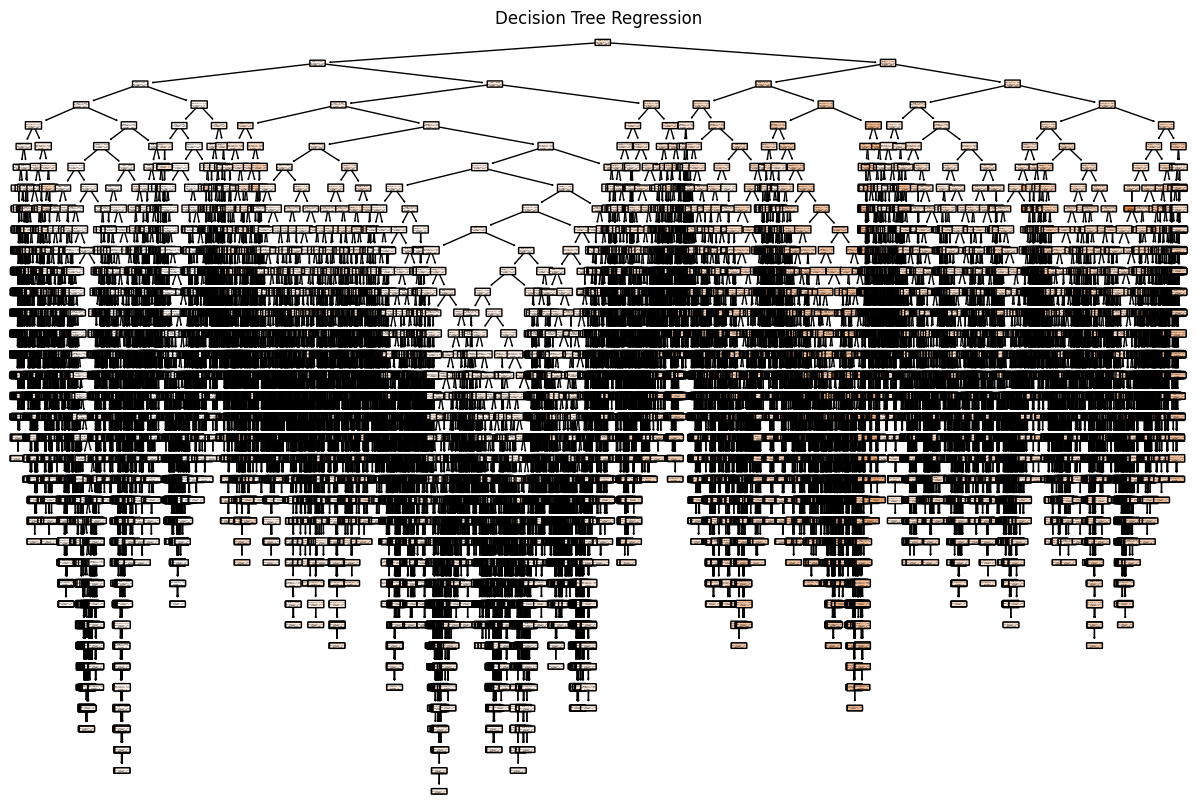

In [65]:
plt.figure(figsize=(15, 10))
plot_tree(dtr, filled=True, feature_names=X.columns, rounded=True)
plt.title('Decision Tree Regression')
plt.show()

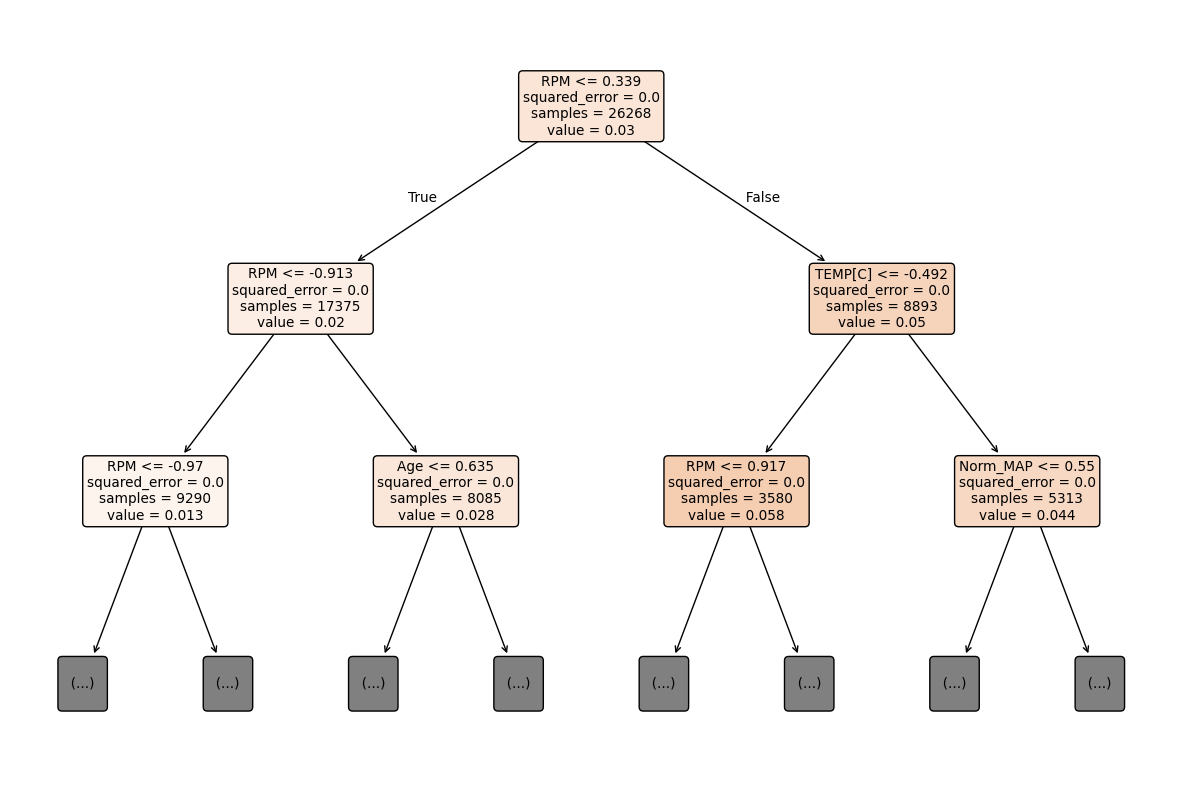

In [66]:
plt.figure(figsize=(15, 10))
plot_tree(dtr,max_depth=2, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [69]:
rules = export_text(dtr, feature_names=list(X.columns))
print(rules)

|--- RPM <= 0.34
|   |--- RPM <= -0.91
|   |   |--- RPM <= -0.97
|   |   |   |--- Age <= -1.88
|   |   |   |   |--- Norm_MAP <= -1.01
|   |   |   |   |   |--- RPM <= -1.06
|   |   |   |   |   |   |--- RPM <= -1.13
|   |   |   |   |   |   |   |--- RPM <= -1.28
|   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |--- RPM >  -1.28
|   |   |   |   |   |   |   |   |--- RPM <= -1.13
|   |   |   |   |   |   |   |   |   |--- RPM <= -1.14
|   |   |   |   |   |   |   |   |   |   |--- RPM <= -1.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- RPM >  -1.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |--- RPM >  -1.14
|   |   |   |   |   |   |   |   |   |   |--- Norm_MAP <= -1.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- Norm_MAP >  -1.08
|   |   |  

In [34]:
dtr_table = pd.DataFrame({
    'Predicted NOx (g/s)': y_pred,
    'Actual NOx (g/s)': y_test,
    'Error': np.abs(y_pred - y_test)
})

print(dtr_table)

       Predicted NOx (g/s)  Actual NOx (g/s)     Error
29675             0.034920           0.03617  0.001250
4918              0.066130           0.06710  0.000970
10376             0.031110           0.02744  0.003670
8094              0.051620           0.04414  0.007480
24761             0.012165           0.01547  0.003305
...                    ...               ...       ...
19807             0.023543           0.02237  0.001173
12266             0.007144           0.00798  0.000836
8139              0.043495           0.04986  0.006365
37116             0.024690           0.02438  0.000310
9871              0.014210           0.02859  0.014380

[11259 rows x 3 columns]


In [35]:
# dtr_table.to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\HASIL\DTR_Prediction.xlsx', index=False)

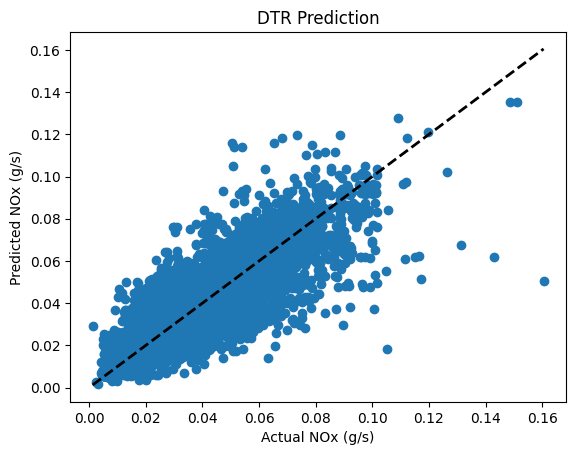

In [36]:
# Assuming y_train and y_train_pred are defined and contain your training data
plt.scatter(y_test, y_pred, label='Test Data')  # Plot test data

# Add a diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add labels and title
plt.xlabel('Actual NOx (g/s)')
plt.ylabel('Predicted NOx (g/s)')
plt.title('DTR Prediction')


# Show the plot
plt.show()

### K-fold CV

In [37]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

In [38]:
scores = cross_val_score(dtr, X_train_scaled, y_train, cv=5, scoring=rmse_scorer)
scores

array([0.00826087, 0.00799845, 0.00796399, 0.00819332, 0.00801526])

In [39]:
print("Mean cross-validation score: {:.7f} ± {:.7f}".format(scores.mean(), scores.std()))

Mean cross-validation score: 0.0080864 ± 0.0001180


### Evaluate

In [40]:
y_train_pred = dtr.predict(X_train_scaled)

In [41]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {rmse_train}')

# Calculate MAPE
mape_train= mean_absolute_percentage_error(y_train, y_train_pred)*100
print(f'MAPE: {mape_train}%')

r2_train= r2_score(y_train, y_train_pred)
print(f'R2: {r2_train}')

RMSE: 0.0013327379676453593
MAPE: 2.9165037209060567%
R2: 0.9952313095735541


In [42]:
print('Training set score: {:.4f}'.format(dtr.score(X_train_scaled, y_train)))

print('Test set score: {:.4f}'.format(dtr.score(X_test_scaled, y_test)))

Training set score: 0.9952
Test set score: 0.8149


In [43]:
# Calculate MSE
dtr_mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {dtr_mse}')

# Calculate MAE
dtr_mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {dtr_mae}')

# Calculate RMSE
dtr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {dtr_rmse}')

# Calculate MAPE
dtr_mape = mean_absolute_percentage_error(y_test,y_pred)*100
print(f'MAPE: {dtr_mape}%')

# Calculate R2
dtr_r2 = r2_score(y_test, y_pred)
print(f'R2: {dtr_r2}')

MSE: 7.200327457477196e-05
MAE: 0.004947147219496378
RMSE: 0.008485474328213595
MAPE: 17.195132189539063%
R2: 0.8149412661027755


In [44]:
importance = dtr.feature_importances_


column_names = X_train.columns

for i, v in enumerate(importance):
    print(f'Feature {column_names[i]}: {v}')

Feature HP(watt): 0.008688622033214207
Feature Norm_MAP: 0.08345099168128926
Feature RPM: 0.7593436373024669
Feature Age: 0.048667896670094093
Feature Engine_Tier: 0.009353228884523165
Feature TEMP[C]: 0.09049562342841237


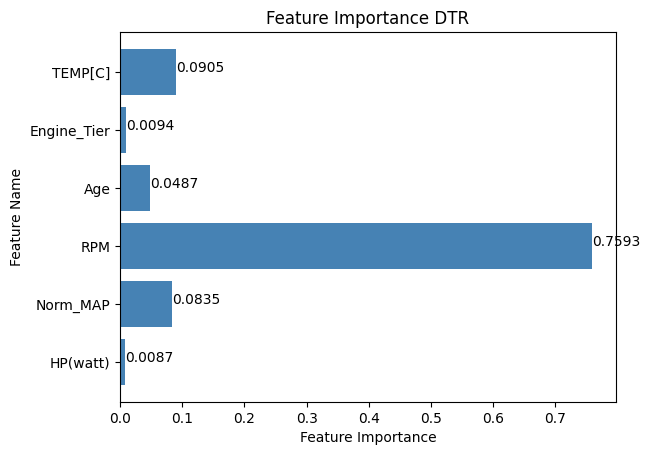

In [45]:
feature_importances = dtr.feature_importances_
feature_names = X_train.columns

# Create the horizontal bar chart
plt.barh(feature_names, feature_importances, color= 'steelblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance DTR')

# Annotate each bar with the feature importance value
for index, value in enumerate(feature_importances):
    plt.text(value, index, f'{value:.4f}')  # Format the value to two decimal places

plt.show()

## Hyperparameter Tuning

In [46]:
param = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [47]:
grid = GridSearchCV(
    dtr,
    param,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring= {'RMSE': rmse_scorer},
    refit='RMSE'
)

start_time = time.time()
grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Best RMSE:", grid.best_score_)
print("Execution time: " + str((time.time() - start_time)) + ' s')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best: 0.007296 using {'criterion': 'friedman_mse', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best RMSE: 0.007295821885437391
Execution time: 245.2451412677765 s


c:\Users\MSI\nafienv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [48]:
cv_df = pd.DataFrame(grid.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE
0,0.055745,0.004125,0.004406,0.001617,squared_error,10,1,10,"{'criterion': 'squared_error', 'max_depth': 10...",0.006490,0.006786,0.006845,0.006883,0.006873,0.006775,0.000147,118
1,0.057006,0.009474,0.026631,0.027731,squared_error,10,1,12,"{'criterion': 'squared_error', 'max_depth': 10...",0.006506,0.006708,0.006825,0.006879,0.006823,0.006748,0.000133,126
2,0.059195,0.010277,0.003306,0.001348,squared_error,10,1,14,"{'criterion': 'squared_error', 'max_depth': 10...",0.006508,0.006698,0.006828,0.006818,0.006856,0.006742,0.000129,133
3,0.054544,0.002564,0.002394,0.000490,squared_error,10,2,10,"{'criterion': 'squared_error', 'max_depth': 10...",0.006472,0.006783,0.006795,0.006794,0.006870,0.006743,0.000139,130
4,0.058785,0.008220,0.002126,0.000453,squared_error,10,2,12,"{'criterion': 'squared_error', 'max_depth': 10...",0.006485,0.006757,0.006796,0.006838,0.006849,0.006745,0.000134,128


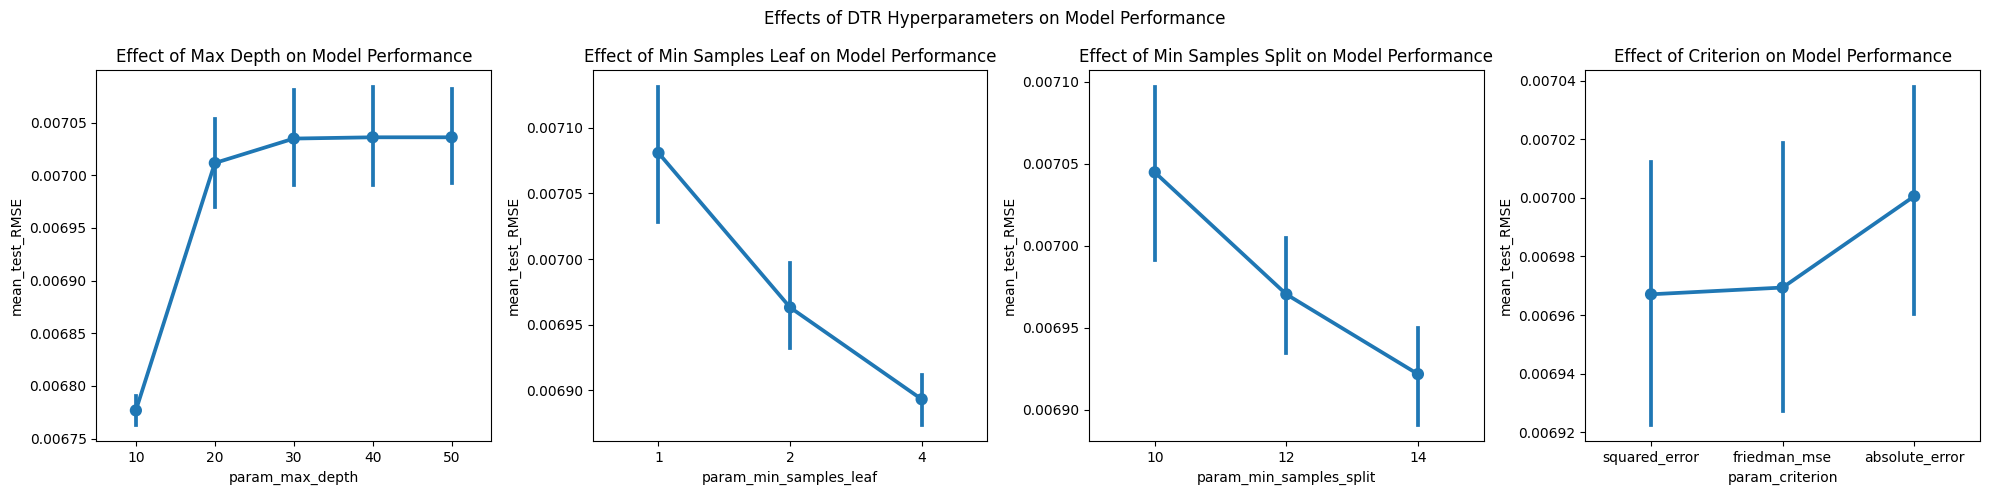

In [49]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Point plot for param_max_depth
sns.pointplot(x='param_max_depth', y='mean_test_RMSE', data=cv_df, ax=axs[0])
axs[0].set(title="Effect of Max Depth on Model Performance")

# Point plot for param_min_samples_leaf
sns.pointplot(x='param_min_samples_leaf', y='mean_test_RMSE', data=cv_df, ax=axs[1])
axs[1].set(title="Effect of Min Samples Leaf on Model Performance")

# Point plot for param_min_samples_split
sns.pointplot(x='param_min_samples_split', y='mean_test_RMSE', data=cv_df, ax=axs[2])
axs[2].set(title="Effect of Min Samples Split on Model Performance")

# Point plot for param_criterion
sns.pointplot(x='param_criterion', y='mean_test_RMSE', data=cv_df, ax=axs[3])
axs[3].set(title="Effect of Criterion on Model Performance")

fig.suptitle("Effects of DTR Hyperparameters on Model Performance")

plt.tight_layout()
plt.show()

In [50]:
# pd.DataFrame(grid.cv_results_).to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\TUNING\Grid_DTR_CV.xlsx', index=False)

In [51]:
best_grid = grid.best_estimator_
best_grid

DecisionTreeRegressor(criterion='friedman_mse', max_depth=40,
                      min_samples_split=10, random_state=42)

In [52]:
y_pred_grid = best_grid.predict(X_test_scaled)

In [53]:
print('Training set score: {:.4f}'.format(best_grid.score(X_train_scaled, y_train)))

print('Test set score: {:.4f}'.format(best_grid.score(X_test_scaled, y_test)))

Training set score: 0.9572
Test set score: 0.8539


In [54]:
# Calculate MSE
mse_grid = mean_squared_error(y_test, y_pred_grid)
print(f'MSE: {mse_grid}')

# Calculate MAE
mae_grid = mean_absolute_error(y_test, y_pred_grid)
print(f'MAE: {mae_grid}')

# Calculate RMSE
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
print(f'RMSE: {rmse_grid}')

# Calculate MAPE
mape_grid = mean_absolute_percentage_error(y_test,y_pred_grid)*100
print(f'MAPE: {mape_grid}%')

# Calculate R2
r2_grid = r2_score(y_test, y_pred_grid)
print(f'R2: {r2_grid}')

MSE: 5.683718584594772e-05
MAE: 0.00447029095923365
RMSE: 0.007539044093646603
MAPE: 15.87837875781251%
R2: 0.8539202874723473


In [55]:
y_train_pred_grid = best_grid.predict(X_train_scaled)

In [56]:
rmse_grid_train = np.sqrt(mean_squared_error(y_train, y_train_pred_grid))
print(f'RMSE: {rmse_grid_train}')

# Calculate MAPE
mape_grid_train= mean_absolute_percentage_error(y_train, y_train_pred_grid)*100
print(f'MAPE: {mape_grid_train}%')

r2_grid_train= r2_score(y_train, y_train_pred_grid)
print(f'R2: {r2_grid_train}')

RMSE: 0.003994796288168323
MAPE: 8.749767624644221%
R2: 0.9571551265264134


In [ ]:
grid_table = pd.DataFrame({
    'Predicted NOx (g/s)': y_pred_grid,
    'Actual NOx (g/s)': y_test,
    'Error': np.abs(y_pred_grid - y_test)
})

print(grid_table)

       Predicted NOx (g/s)  Actual NOx (g/s)     Error
29675             0.035245           0.03617  0.000925
4918              0.062297           0.06710  0.004803
10376             0.026301           0.02744  0.001139
8094              0.045865           0.04414  0.001725
24761             0.012165           0.01547  0.003305
...                    ...               ...       ...
19807             0.023490           0.02237  0.001120
12266             0.007144           0.00798  0.000836
8139              0.041658           0.04986  0.008203
37116             0.025208           0.02438  0.000828
9871              0.021063           0.02859  0.007527

[11259 rows x 3 columns]


In [58]:
# grid_table.to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\HASIL\DTR_GRID_Prediction.xlsx', index=False)

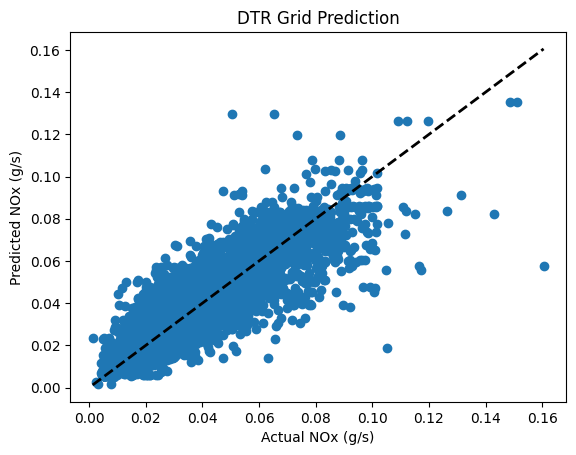

In [59]:
plt.scatter(y_test, y_pred_grid)

# Add a diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add labels and title
plt.xlabel('Actual NOx (g/s)')
plt.ylabel('Predicted NOx (g/s)')
plt.title('DTR Grid Prediction')

# Show the plot
plt.show()

In [60]:
importance_grid = best_grid.feature_importances_


column_names_grid = X_train.columns

for i, v in enumerate(importance_grid):
    print(f'Feature {column_names_grid[i]}: {v}')

Feature HP(watt): 0.025247667162016214
Feature Norm_MAP: 0.07643531680231862
Feature RPM: 0.7695643688421793
Feature Age: 0.03385840119663455
Feature Engine_Tier: 0.008814698060007807
Feature TEMP[C]: 0.08607954793684358


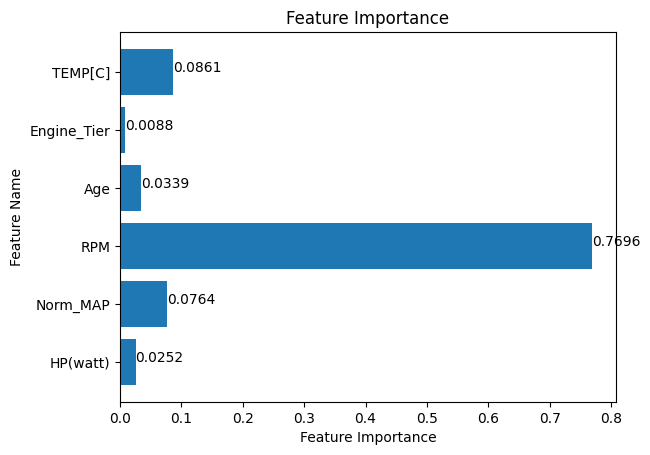

In [61]:
feature_importances_grid = best_grid.feature_importances_
feature_names_grid = X_train.columns

# Create the horizontal bar chart
plt.barh(feature_names_grid, feature_importances_grid)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')

# Annotate each bar with the feature importance value
for index, value in enumerate(feature_importances_grid):
    plt.text(value, index, f'{value:.4f}')  # Format the value to two decimal places

plt.show()

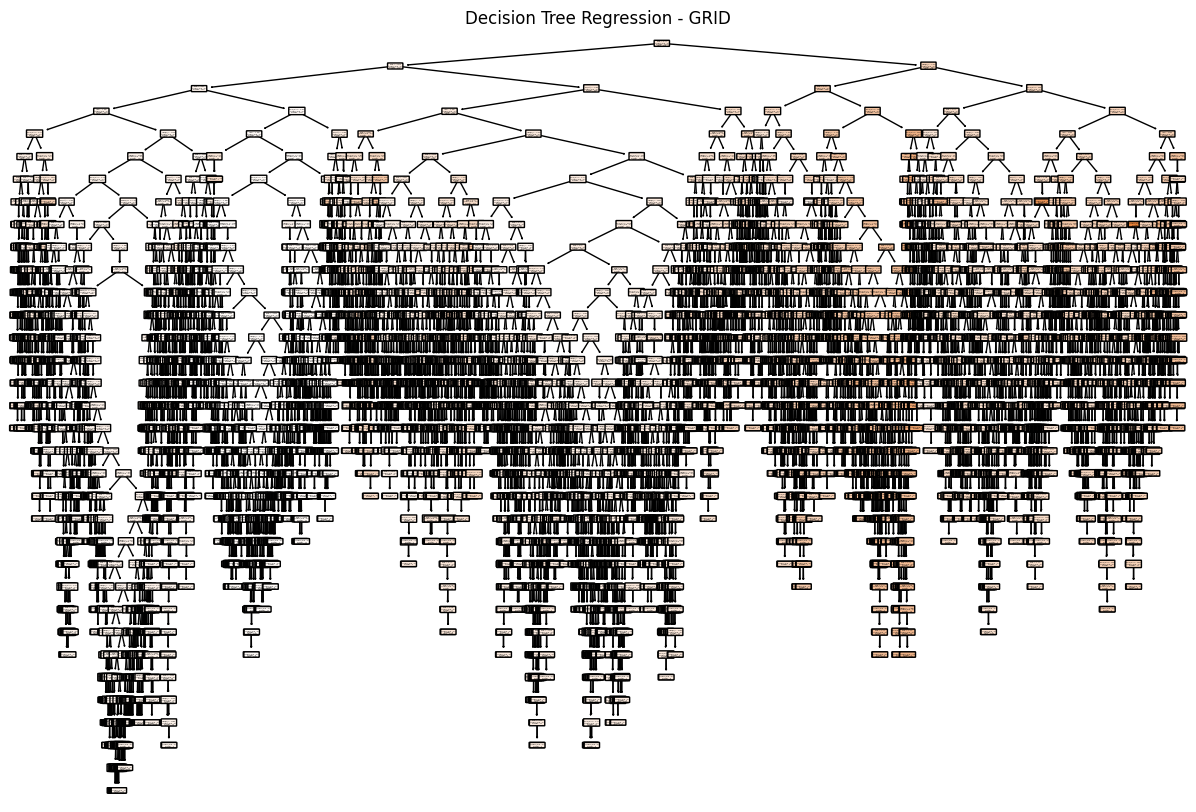

In [64]:
plt.figure(figsize=(15, 10))
plot_tree(best_grid, filled=True, feature_names=X.columns, rounded=True)
plt.title('Decision Tree Regression - GRID')
plt.show()

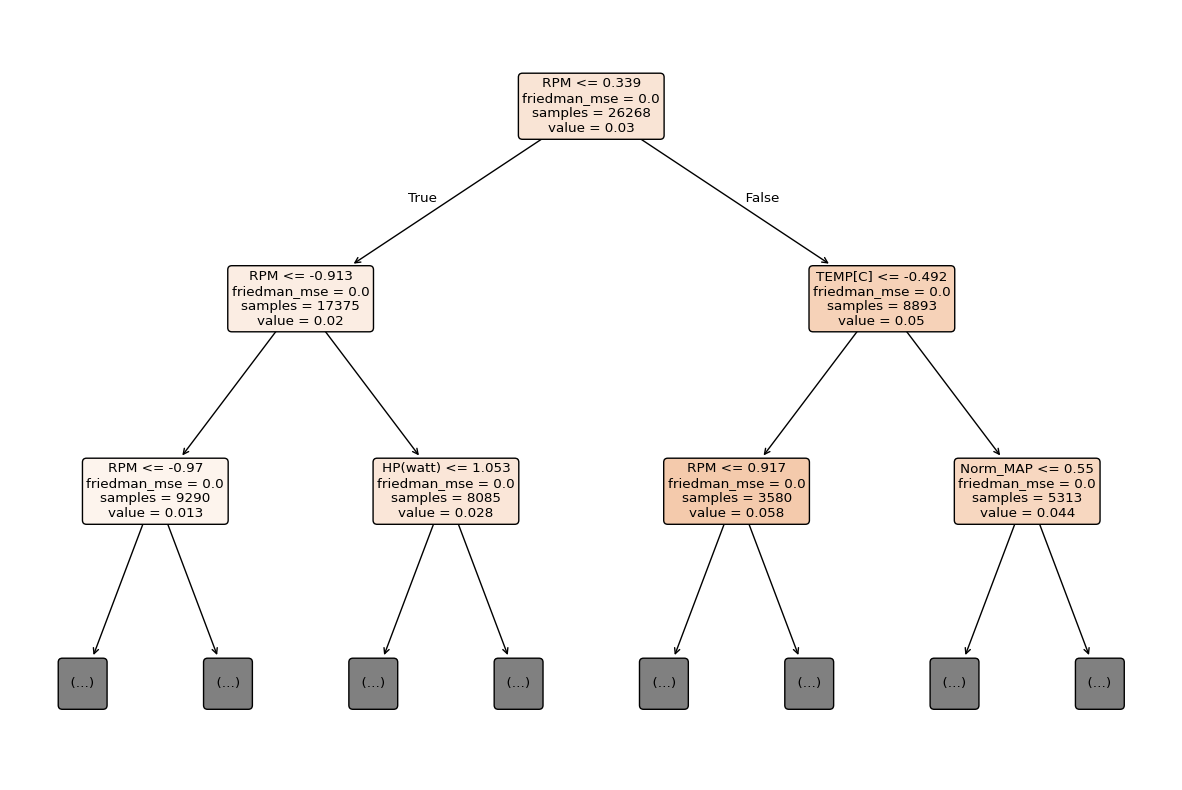

In [63]:
plt.figure(figsize=(15, 10))
plot_tree(best_grid,max_depth=2, filled=True, feature_names=X.columns, rounded=True)
plt.show()

In [67]:
rules_grid = export_text(best_grid, feature_names=list(X.columns))
print(rules_grid)

|--- RPM <= 0.34
|   |--- RPM <= -0.91
|   |   |--- RPM <= -0.97
|   |   |   |--- Age <= -1.88
|   |   |   |   |--- Norm_MAP <= -1.01
|   |   |   |   |   |--- RPM <= -1.06
|   |   |   |   |   |   |--- RPM <= -1.13
|   |   |   |   |   |   |   |--- RPM <= -1.28
|   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |--- RPM >  -1.28
|   |   |   |   |   |   |   |   |--- RPM <= -1.13
|   |   |   |   |   |   |   |   |   |--- RPM <= -1.14
|   |   |   |   |   |   |   |   |   |   |--- RPM <= -1.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- RPM >  -1.15
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   |   |--- RPM >  -1.14
|   |   |   |   |   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |   |   |   |   |--- RPM >  -1.13
|   |   |   |   |   |   |   |   |   |--- Norm_MAP <= -1.08
|   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
| 